In [1]:
# face detection for the mask Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)
 
# load train dataset
trainX, trainy = load_dataset('mask_face_dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('mask_face_dataset/valid/')
# save arrays to one file in compressed format
savez_compressed('train_valid_npz/mask_face_dataset_T_V.npz', trainX, trainy, testX, testy)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
>loaded 78 examples for class: fa
>loaded 78 examples for class: ff
>loaded 78 examples for class: fi
>loaded 78 examples for class: fj
>loaded 78 examples for class: fk
>loaded 78 examples for class: ma
>loaded 78 examples for class: mb
>loaded 78 examples for class: mc
>loaded 78 examples for class: md
>loaded 78 examples for class: mf
>loaded 78 examples for class: mh
>loaded 78 examples for class: mi
>loaded 78 examples for class: mk
>loaded 78 examples for class: ml
>loaded 78 examples for class: mp
>loaded 78 examples for class: mr
>loaded 78 examples for class: mu
>loaded 78 examples for class: mv
>loaded 78 examples for class: mw
>loaded 78 examples for class: mx
(1560, 160, 160, 3) (1560,)
>loaded 18 examples for class: fa
>loaded 18 examples for class: ff
>loaded 18 examples for class: fi
>loaded 18 examples for class: fj
>loade

In [10]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
 
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = load('train_valid_npz/mask_face_dataset_T_V.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format
savez_compressed('train_valid_npz/mask_faces_embeddings_T_V.npz', newTrainX, trainy, newTestX, testy)

Using TensorFlow backend.


Loaded:  (1560, 160, 160, 3) (1560,) (360, 160, 160, 3) (360,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\Sabbir\.conda\envs\mask_face\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(1560, 128)
(360, 128)


In [11]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

# load dataset
data = load('train_valid_npz/mask_faces_embeddings_T_V.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
yhat_prob_test=model.predict_proba(testX)

# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)

# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=1560, test=360
Accuracy: train=99.936, test=100.000


Predicted: mi (60.089)
Expected: mi


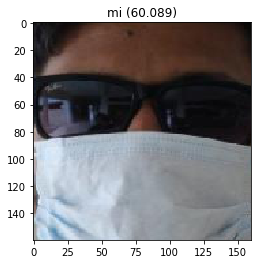

In [19]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

# load faces
data = load('train_valid_npz/mask_face_dataset_T_V.npz')
testX_faces = data['arr_2']

# load face embeddings
data = load('train_valid_npz/mask_faces_embeddings_T_V.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0]
 [ 0  0  0  0  

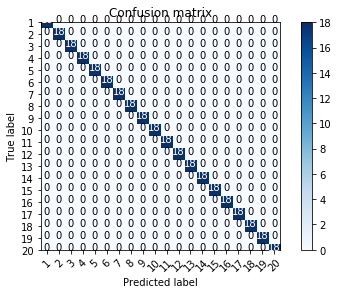

In [21]:
cm=confusion_matrix(testy, yhat_test)
plot_confusion_matrix(cm,['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])

In [22]:
from sklearn.metrics import classification_report
print(classification_report(testy,yhat_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        18
           5       1.00      1.00      1.00        18
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        18
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        18
          10       1.00      1.00      1.00        18
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        18
          13       1.00      1.00      1.00        18
          14       1.00      1.00      1.00        18
          15       1.00      1.00      1.00        18
          16       1.00      1.00      1.00        18
          17       1.00    

C:\Users\Sabbir\.conda\envs\mask_face\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


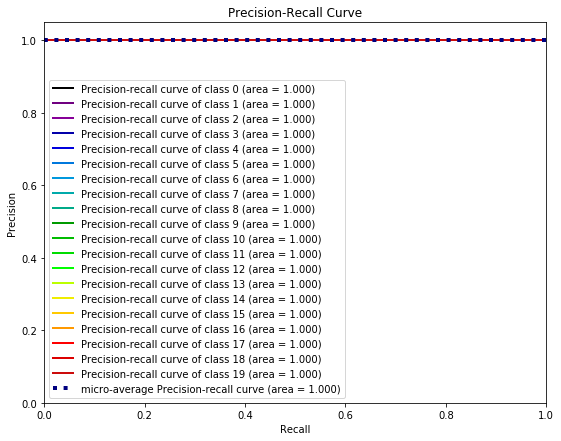

In [23]:
# Import what's needed for the Functions API
import matplotlib.pyplot as plt
import scikitplot as skplt

# Now plot.
skplt.metrics.plot_precision_recall_curve(testy,yhat_prob_test,figsize=(9,7))
plt.show()

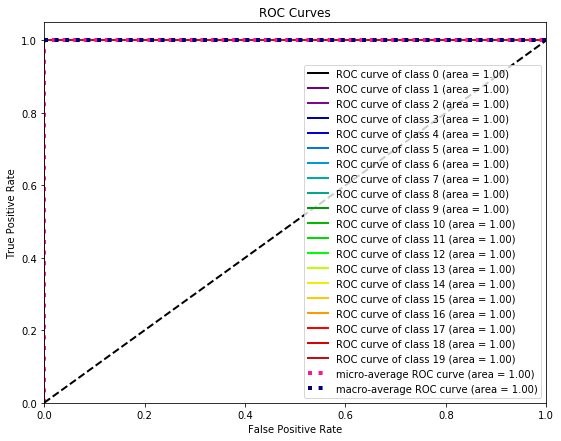

In [24]:
# The magic happens here
skplt.metrics.plot_roc(testy, yhat_prob_test,figsize=(9,7))
plt.show()

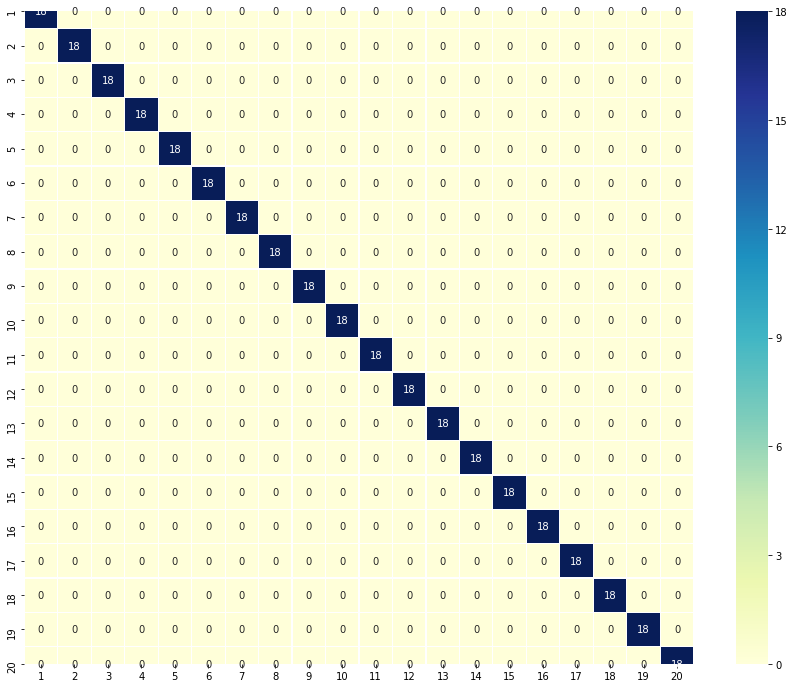

In [25]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'],
                  columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
plt.figure(figsize = (15,12))
sn.heatmap(df_cm, annot=True,linewidths=.15,cmap="YlGnBu")